In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from kneed import KneeLocator
import collections
from sklearn.model_selection import cross_validate

In [2]:
#Configuración de dataset a utilizar

data = pd.read_csv("../data/preprocessed_data/Mhealth_50_50.csv")
data.drop(["Sensor", "ID", "DTS", ], axis=1, inplace=True)

subjects = data["Subject"]

data.drop("Subject", axis=1, inplace=True)

Y_tChest = data["Activity"]
Y_tLA = data["Activity"]
Y_tRLA = data["Activity"]

data.drop("Activity", axis=1, inplace=True)

X = data[data.columns.to_list()]

X_tChest = X.filter(like='tChest')
X_tLA = X.filter(like='tLA')
X_tRLA = X.filter(like='tRLA')

X_tLA.head()

,max_Acctr_tLA_X(m/s2),max_Acctr_tLA_Y(m/s2),max_Acctr_tLA_Z(m/s2),max_Gype_tLA_X(deg/s),max_Gype_tLA_Y(deg/s),max_Gype_tLA_Z(deg/s),max_MgFld_tLA_X(T),max_MgFld_tLA_X(uT),max_MgFld_tLA_Y(T),max_MgFld_tLA_Y(uT),...,var_Acctr_tLA_Z(m/s2),var_Gype_tLA_X(deg/s),var_Gype_tLA_Y(deg/s),var_Gype_tLA_Z(deg/s),var_MgFld_tLA_X(T),var_MgFld_tLA_X(uT),var_MgFld_tLA_Y(T),var_MgFld_tLA_Y(uT),var_MgFld_tLA_Z(T),var_MgFld_tLA_Z(uT)
0,2.6634,-9.2129,0.76847,-0.19481,-0.86867,-0.49116,9.248300e-07,0.92483,1.282200e-06,1.28220,...,0.009780,0.000046,0.000061,0.000048,5.705575e-14,0.057056,8.920655e-14,0.089207,2.915137e-14,0.029151
1,2.6093,-9.2129,0.76847,-0.19109,-0.86492,-0.49312,9.119500e-07,0.91195,1.285900e-06,1.28590,...,0.010106,0.000086,0.000090,0.000028,6.046168e-14,0.060462,7.015725e-14,0.070157,2.441001e-14,0.024410
2,2.5812,-9.2524,0.74815,-0.19109,-0.86492,-0.49509,5.550000e-07,0.55500,1.285900e-06,1.28590,...,0.009453,0.000068,0.000058,0.000048,4.894095e-14,0.048941,4.614097e-14,0.046141,2.013159e-14,0.020132
3,2.5698,-9.4029,0.60175,-0.20223,-0.86679,-0.49509,9.163400e-07,0.91634,9.136900e-07,0.91369,...,0.006969,0.000070,0.000046,0.000069,4.752568e-14,0.047526,3.013656e-14,0.030137,2.164514e-14,0.021645
4,2.6123,-9.2738,0.67359,-0.20408,-0.86867,-0.49509,9.163400e-07,0.91634,9.082700e-07,0.90827,...,0.008641,0.000065,0.000047,0.000050,3.971683e-14,0.039717,2.413543e-14,0.024135,3.751596e-14,0.037516


In [3]:
#Partición de datos

x_tChest, X_test_tChest, y_tChest , y_test_tChest = train_test_split(X_tChest,Y_tChest,test_size=0.15,random_state=0)
x_tLA, X_test_tLA, y_tLA , y_test_tLA = train_test_split(X_tLA,Y_tLA,test_size=0.15,random_state=0)
x_tRLA, X_test_tRLA, y_tRLA , y_test_tRLA = train_test_split(X_tRLA,Y_tRLA,test_size=0.15,random_state=0)

In [19]:
#Random Forest

max_depth = 15
n_repeats = 30
k_folds = 10

rf = np.zeros(max_depth)
rf_wf1_tChest = np.zeros(max_depth)
rf_wf1_tLA = np.zeros(max_depth)
rf_wf1_tRLA = np.zeros(max_depth)

count = 1

for i in range (1, max_depth + 1):
    rf[count-1] = i
    
    print("RF, n estimators:",i)

    cv = RepeatedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=0)
    
    model = RandomForestClassifier(max_depth=i)
    
    scoring = ['f1_weighted']
    
    scores_tChest = cross_validate(model, x_tChest, y_tChest, scoring=scoring, cv=cv, n_jobs=-1)
    scores_tLA = cross_validate(model, x_tLA, y_tLA, scoring=scoring, cv=cv, n_jobs=-1)
    scores_tRLA = cross_validate(model, x_tRLA, y_tRLA, scoring=scoring, cv=cv, n_jobs=-1)
    
    rf_wf1_tChest[count - 1] = scores_tChest['test_f1_weighted'].mean()
    rf_wf1_tLA[count - 1] = scores_tLA['test_f1_weighted'].mean()
    rf_wf1_tRLA[count - 1] = scores_tRLA['test_f1_weighted'].mean()
    
    count = count + 1

metrics_df = pd.DataFrame({
    'max_depth': rf,
    'weighted_f1_tChest': rf_wf1_tChest,
    'weighted_f1_tLA': rf_wf1_tLA,
    'weighted_f1_tRLA': rf_wf1_tRLA
}) 

metrics_df.to_csv("D:/Estudios/Tesis/resultados/ult_exp/md/150_25/rf.csv", index=False)

RF, n estimators: 1
RF, n estimators: 2
RF, n estimators: 3
RF, n estimators: 4
RF, n estimators: 5
RF, n estimators: 6
RF, n estimators: 7
RF, n estimators: 8
RF, n estimators: 9
RF, n estimators: 10
RF, n estimators: 11
RF, n estimators: 12
RF, n estimators: 13
RF, n estimators: 14
RF, n estimators: 15


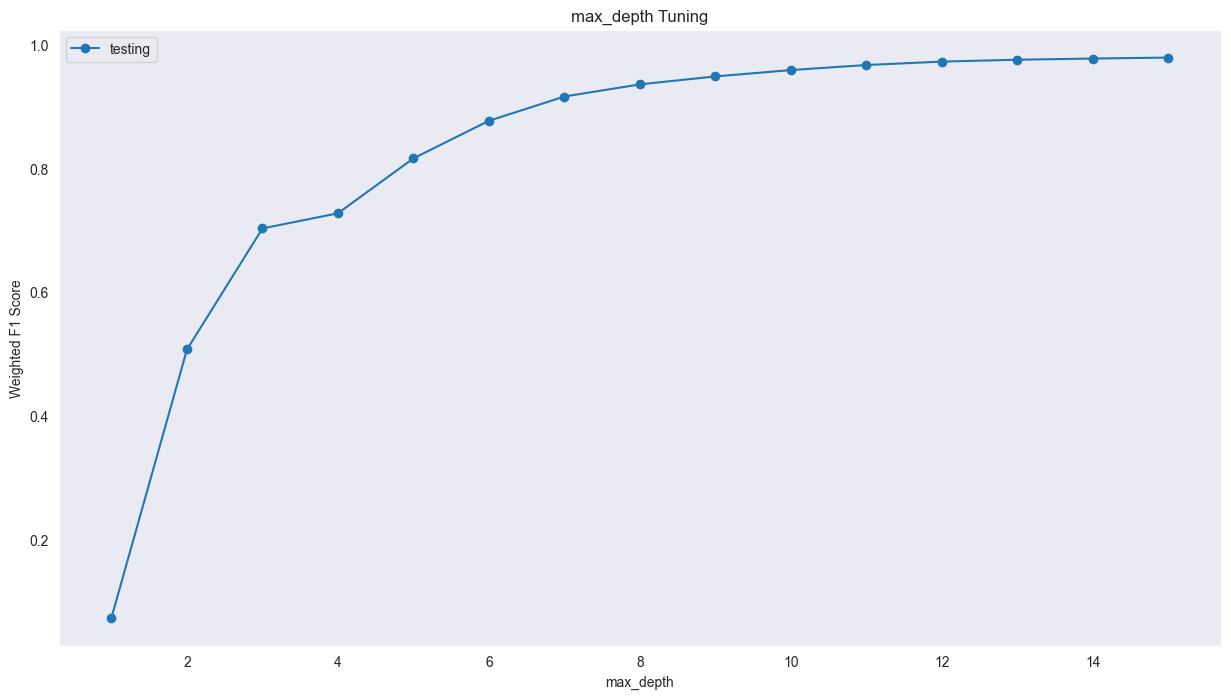

5.0


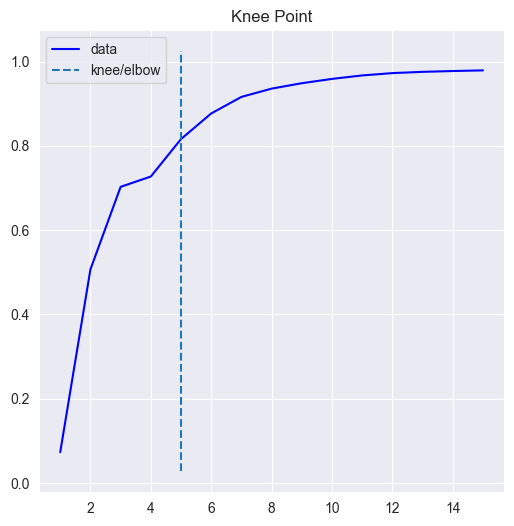

In [4]:
#Resultados de RF
prueba =  pd.read_csv("D:/Estudios/Tesis/resultados/ult_exp/md/50_50/rf.csv")

erf = prueba["max_depth"]
ev = prueba["weighted_f1_tRLA"]

plt.figure(figsize=(15, 8))
plt.plot(erf, ev, '-o', label="testing")
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("Weighted F1 Score")
plt.grid()
plt.title("max_depth Tuning")
plt.show()

kneedle = KneeLocator(erf, ev.tolist(), S=1.0, curve="concave", direction="increasing")
print(round(kneedle.knee, 3))
#kneedle.plot_knee_normalized()
kneedle.plot_knee()



In [6]:
#Creación del modelo y evaluación
o=3
md=5
if o == 1 :
    model = RandomForestClassifier(max_depth=md)
    model.fit(x_tChest, y_tChest)  

    y_test_hat = model.predict(X_test_tChest)

    print(model.score(X_test_tChest,y_test_tChest))
    print(metrics.confusion_matrix(y_test_tChest, y_test_hat))
    print(metrics.classification_report(y_test_tChest, y_test_hat))
elif o == 2:
    model = RandomForestClassifier(max_depth=md)
    model.fit(x_tLA, y_tLA)  

    y_test_hat = model.predict(X_test_tLA)

    print(model.score(X_test_tLA,y_test_tLA))
    print(metrics.confusion_matrix(y_test_tLA, y_test_hat))
    print(metrics.classification_report(y_test_tLA, y_test_hat))
elif o == 3:
    model = RandomForestClassifier(max_depth=md)
    model.fit(x_tRLA, y_tRLA)  

    y_test_hat = model.predict(X_test_tRLA)

    print(model.score(X_test_tRLA,y_test_tRLA))
    print(metrics.confusion_matrix(y_test_tRLA, y_test_hat))
    print(metrics.classification_report(y_test_tRLA, y_test_hat))

0.8352244696595955
[[175   0   0   0   0   0   0   0   0   0   0   0]
 [  0 186   0   0   0   0   0   0   0   0   0   0]
 [  0   0 175   0   0   0   0   0   0   0   0   0]
 [  0   0   0 173   2  23   0   5   0   0   0   0]
 [  0   0   0  42  88  48   3  27   0   0   0   0]
 [  0   0   0   3   9  88   2  70   0   0   0   0]
 [  0   0   0   1   1   0 159   0   0   0   0   0]
 [  0   0   0   5   3  19   4 131   1   0   0   0]
 [  0   0   0   0   0   0   0   0 186   0   0   0]
 [  0   0   0   0   0   0   0   0   0 158  12   0]
 [  0   0   0   0   0   0   0   0   0  15 154   0]
 [  0   0   0   0   0   0   1   0   0  32   6  20]]
              precision    recall  f1-score   support

    MHE_A_01       1.00      1.00      1.00       175
    MHE_A_02       1.00      1.00      1.00       186
    MHE_A_03       1.00      1.00      1.00       175
    MHE_A_04       0.77      0.85      0.81       203
    MHE_A_05       0.85      0.42      0.57       208
    MHE_A_06       0.49      0.51      0.50

In [96]:
#Importancia de features

feature_names = X_tLA.columns

feature_importances = model.feature_importances_

feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importances_df_sorted = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df_sorted.to_csv("D:/Estudios/Tesis/resultados/ult_exp/md/150_25/tLA/ft_importance.csv", index=False)

In [97]:
#Acumulados

acum_trans = collections.defaultdict(float)
acum_disp = collections.defaultdict(float)

for _, row in feature_importances_df.iterrows():
    feature = row["Feature"]
    importance = row["Importance"]
    trans, disp, pos = feature.split("_", 2)
    acum_trans[trans] += importance
    acum_disp[disp] += importance

lista_acum_trans = list(acum_trans.items())
lista_acum_disp = list(acum_disp.items())

df_acum_trans = pd.DataFrame(lista_acum_trans, columns=["Transformación", "Acumulado"])
df_acum_disp = pd.DataFrame(lista_acum_disp, columns=["Dispositivo", "Acumulado"])

df_acum_trans.to_csv("D:/Estudios/Tesis/resultados/ult_exp/md/150_25/tLA/acum_trans.csv", index=False)
df_acum_disp.to_csv("D:/Estudios/Tesis/resultados/ult_exp/md/150_25/tLA/acum_disp.csv", index=False)

In [28]:
#Almacenamiento de resultados del hiperparámetro óptimo
md_chest = 4
md_LA = 4
md_RLA = 4

n_repeats = 30
k_folds = 10

cv = RepeatedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=0)
    
model_tChest = RandomForestClassifier(max_depth=md_chest)
model_tLA = RandomForestClassifier(max_depth=md_LA)
model_tRLA = RandomForestClassifier(max_depth=md_RLA)
    
scoring = ['f1_weighted']
    
scores_tChest = cross_validate(model_tChest, x_tChest, y_tChest, scoring=scoring, cv=cv, n_jobs=-1)
scores_tLA = cross_validate(model_tLA, x_tLA, y_tLA, scoring=scoring, cv=cv, n_jobs=-1)
scores_tRLA = cross_validate(model_tRLA, x_tRLA, y_tRLA, scoring=scoring, cv=cv, n_jobs=-1)

df_test = pd.DataFrame({
    '150_75_tChest': scores_tChest['test_f1_weighted'],
    '150_75_tLA': scores_tLA['test_f1_weighted'],
    '150_75_tRLA': scores_tRLA['test_f1_weighted']
}) 
df_test['id'] = range(1, len(df_test) + 1)

df_test.to_csv("D:/Estudios/Tesis/resultados/ult_exp/md/150_75/150_75.csv", index=False)